<a href="https://colab.research.google.com/github/djbradyAtOpticalSciencesArizona/computationalImaging/blob/master/rays/AlexSamoyAlvaradoHW3_Q4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Alex Samoy-Alvarado
## OPTI 556, 2021 
## Homework 3

### Question 4: the coded aperture tomography code presented in https://github.com/djbradyAtOpticalSciencesArizona/computationalImaging/blob/master/rays/codedApertureTomography.ipynb describes 2D reconstruction from 1D measurement data. Build a forward model for a system that measures a similar 2D object space from two different angles (e.g. with a coded aperture normal to the x-axis and a coded aperture normal to the y-axis.) How does this system perform compared to the single look system?

*Import modules/libraries*

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from scipy import signal
from scipy import integrate
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 10]
plt.rcParams.update({'font.size': 22})
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
import cv2
from keras.datasets import mnist

plt.rcParams['figure.figsize'] = [20, 10]

*This question involves 2D reconstruction from 1D measurement data. This is to simulate light from a 2D object passing through a coded aperture and getting measured on a 1D array of pixels.*

*To run this simulation, we must first create an H matrix for our forward model. This H matrix is designed to simulate the transmission of the light through the coded aperture, t, and onto the 1D array of pixels. In this case, the coded aperture and 1D detector are along X.*

*The code below is to generate our forward model matrix, H. The coded aperture embedded in that model is random.*

In [ ]:
l= 10
delta=1
N=28
M=128
code=np.random.randint(0,2,M)
def t(x):
  t=code[np.int(np.floor((x+M/2)/delta))]
  return t
vt=np.vectorize(t)
def p(j):
  xj, yj=delta*divmod(j,N)
  xj=xj-N*delta/2
  yj=yj+l
  return xj, yj
def g(j,x):
  g=t((x+(l/p(j)[1])*p(j)[0])/(1+(l/p(j)[1])))
  return g
def h(i,j):
  h=integrate.quad(lambda x: g(j,x), (i-M/2)*delta-delta/2,(i-M/2)*delta +delta/2)[0]
  return h
H=np.zeros((M,N**2))
for j in range(N**2):
  for i in range(M):
    H[i,j]=h(i,j)

*Below is a figure representing the coded aperture, t. It spans a 128x1 array, and it shows 1 for transmission zones and 0 for zones that block transmission.*

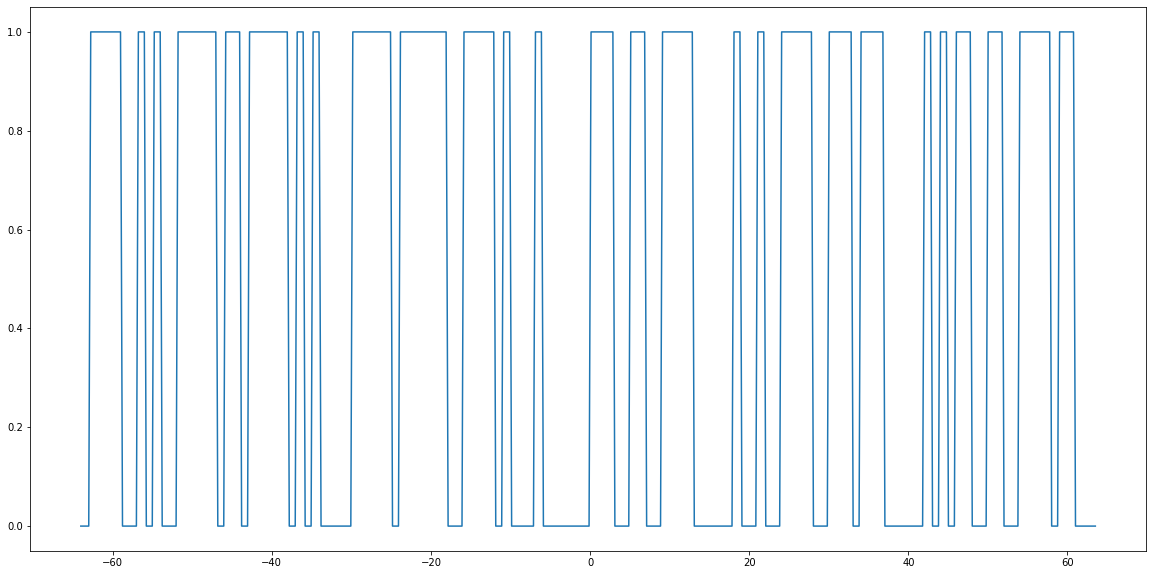

In [ ]:
plt.rcParams['figure.figsize'] = [20, 10]

xspace=np.linspace(-M*delta/2,(M-1)*delta/2,512)
plt.plot(xspace,vt(xspace))

*Since our object is represented as a discrete set of values, 28x28 in size (raster form), each row of H corresponds to a measurement projection for a single pixel.* 

*In other words, 784 object element projections (one for each raster form value) go through the coded aperture and land on pixel 1. These projections are arranged into the first row of H. This process is repeated for 128 pixels, which make 128 rows of H. Therefore, H is 128 rows (one for each pixel), and 784 columns (1 for each projection from the raster object to an individual pixel).*

*Below is a figure representation of H after all projections onto each pixel have been arranged.*

(128, 784)


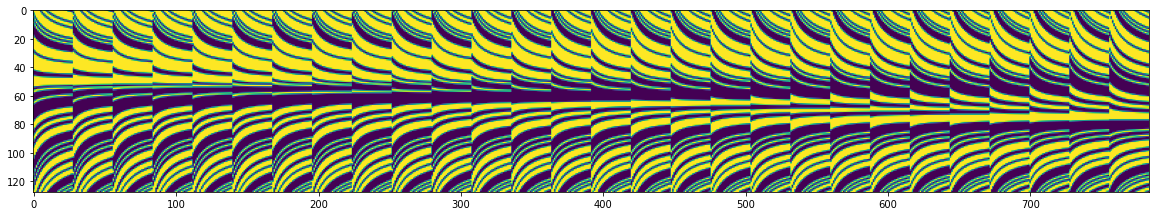

In [ ]:
plt.imshow(H)
print(H.shape)

*Now that we have built our first model of H, we can simply use its pseudoinverse to do linear reconstruction of measured data. We can refine this pseudoinverse by taking projections along different directions and coming up with a more comprehensive model for H. Examples will be shown below.*

*Load test data*

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0

11501568/11490434 [==============================] - 0s 0us/step


*Below is an example object we will use for our model.*

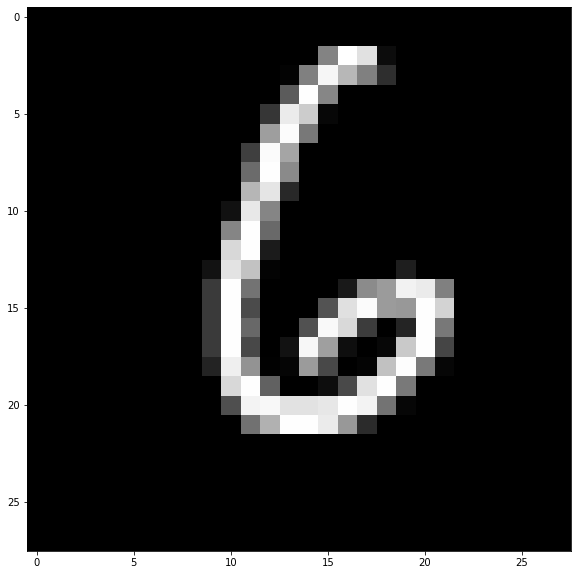

In [ ]:
plt.imshow(x_train[32],cmap='gray')

*After projecting this raster object 'f' through our forward model matrix 'H,' we will get a 1D set of 128 measurement values. We will then use the pseudoinverse of H to try and reconstruct an image that resembles the object.* 

*Here is an example of the 128, 1D measurement values after running the above raster image of the number 6 through the forward model. If g = Hf, this is our measurement 'g.'*

([], <a list of 0 Text major ticklabel objects>)

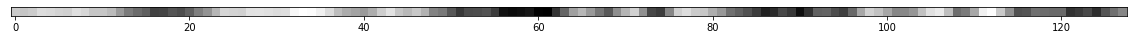

In [ ]:
g = np.reshape(np.matmul(H,np.reshape(x_train[32],N**2)),(1,128))
plt.imshow(g, cmap='gray')
plt.yticks([])

*Now we can use pseudoinverse based linear reconstruction methods to take the 1D measurement data and recreate a 2D image. The method used below is essentially Ordinarly Least Squares estimation, or OLS. Note that a pseudoinverse is necessary since H is not full rank.*

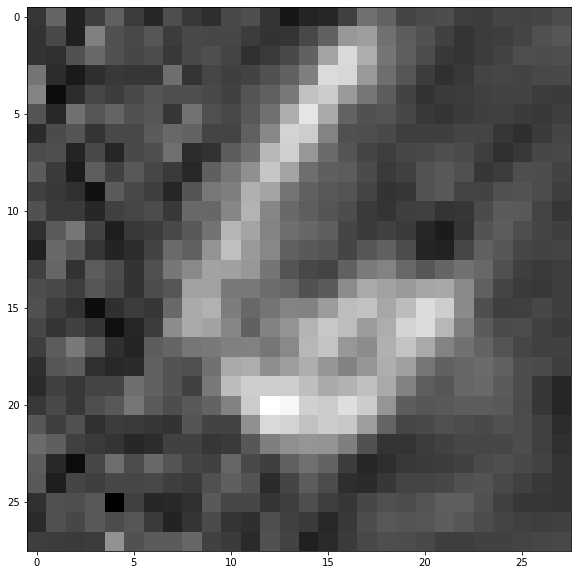

In [ ]:
H_=np.reshape(np.matmul(np.linalg.pinv(H),np.matmul(H,np.reshape(x_train[32],N**2))),(N,N))
plt.imshow(H_, cmap='gray')

*Note that this linear estimation method does an OK job of reconstructing the number 6. However, the resolution and contrast is worse than it could be, and the image gets blurrier from left to right. This is representative of ray projections scattering as they pass through a material. Since we projected along the x axis, scattering/blurring occurs as we increase x, or move to the right.*

*We can see this effect in the opposite direction if we rotate H by 180 degrees. Since the coded aperture 't' is embedded in our model of H, this is representative of having the coded aperture now facing our object from the negative x direction. Our rays will now interact with the object from the other side.*

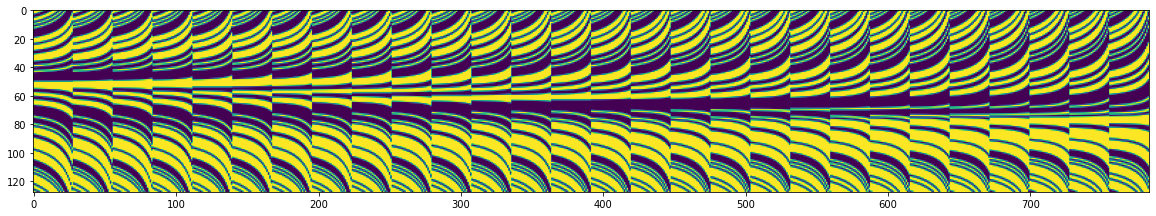

In [ ]:
Hrot=np.rot90(H)
Hrot=np.rot90(Hrot)
plt.imshow(Hrot)

*Note that the pattern of H above has flipped, and the curves are facing the opposite direction. Now if we apply our new H to the object and reconstruct the image using a pseudoinverse, we will see the blurring pattern has shifted from left to right and now is oriented from right to left. See how the new reconstruction of the number 6 gets blurrier as we move from right to left.*

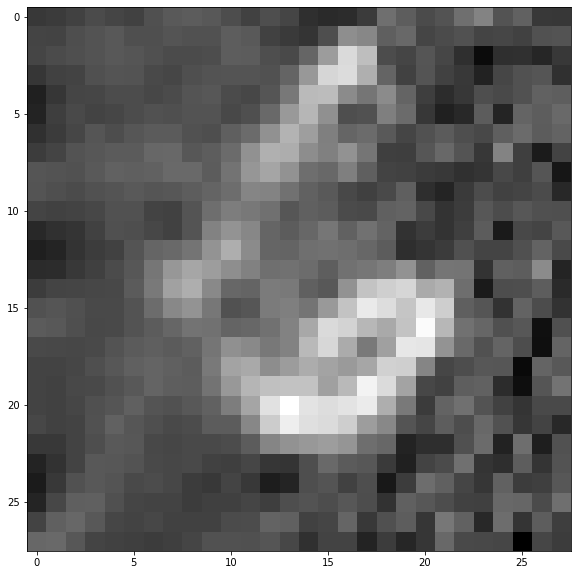

In [ ]:
H_rot=np.reshape(np.matmul(np.linalg.pinv(Hrot),np.matmul(Hrot,np.reshape(x_train[32],N**2))),(N,N))
plt.imshow(H_rot, cmap='gray')

*Here are side by side comparisons of projecting through H from the positve x direction, and projecting through H from the negative x direction. It is easy to see the flip in the direction of the blur.*

Text(0.5, 1.0, 'Projection from Negative X')

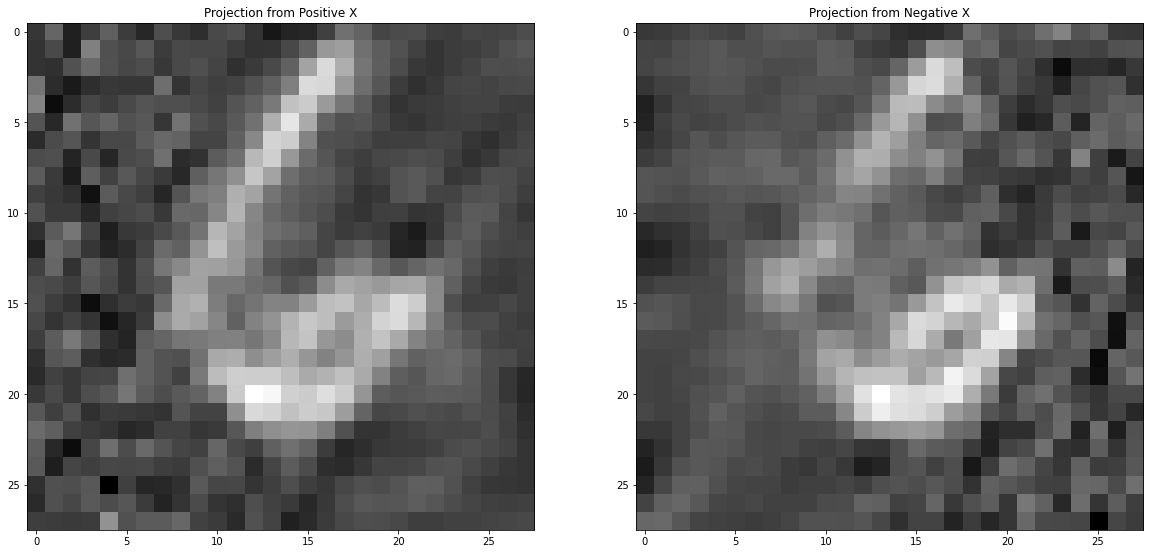

In [ ]:
plt.subplot(1,2,1)
plt.imshow(H_, cmap='gray')
plt.title('Projection from Positive X')

plt.subplot(1,2,2)
plt.imshow(H_rot, cmap='gray')
plt.title('Projection from Negative X')

*If we could combine the information from these images, we could render a better reconstruction of the image. As it happens, if we concatenate the H matracies and use the concatenated version of the psuedoinverse, we can achive this desired result.*

*This is because if g = Hf, then [g1;g2] = [H1;H2]f  Thus, the psuedoinverse of [H1;H2] is valid to use for a linear reconstruction of f.* 

*Below is a figure of H concatenated with H rotated by 180 degrees.*

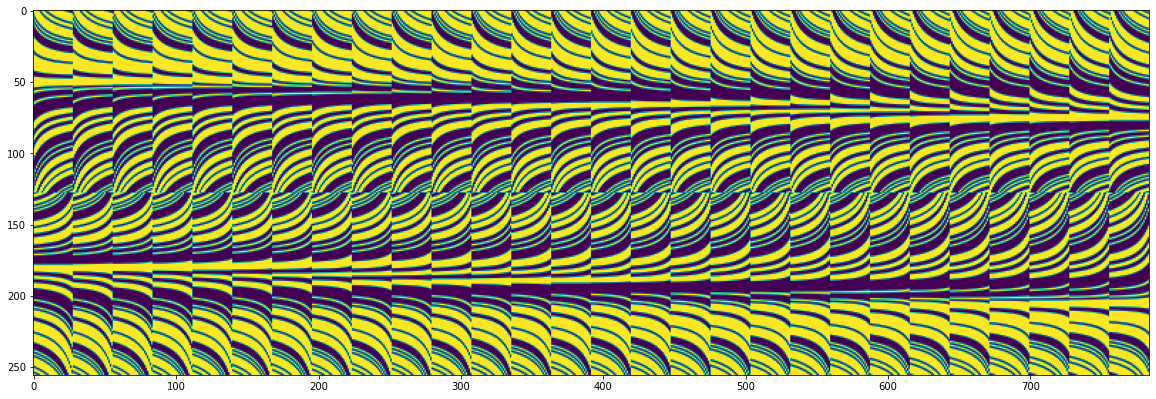

In [ ]:
Htot=np.concatenate((H,Hrot), axis=0)
plt.imshow(Htot)

*Now if we apply the psuedoinverse of this concatenated matrix to the image reconstruction, we get a better result.*

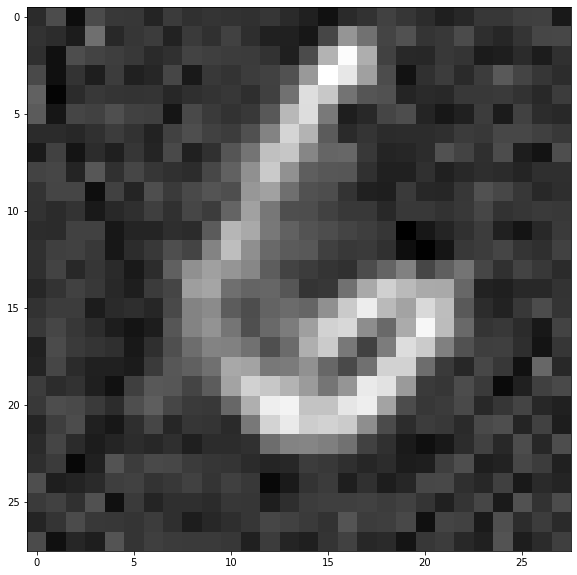

In [ ]:
H_tot=np.reshape(np.matmul(np.linalg.pinv(Htot),np.matmul(Htot,np.reshape(x_train[32],N**2))),(N,N))
plt.imshow(H_tot, cmap='gray')

*Here are side by side comparison of reconstruction from positive X projection, reconstruction from negative X projection, and reconstruction from concatenation of both projections.*

Text(0.5, 1.0, 'Concatenated Reconstruction')

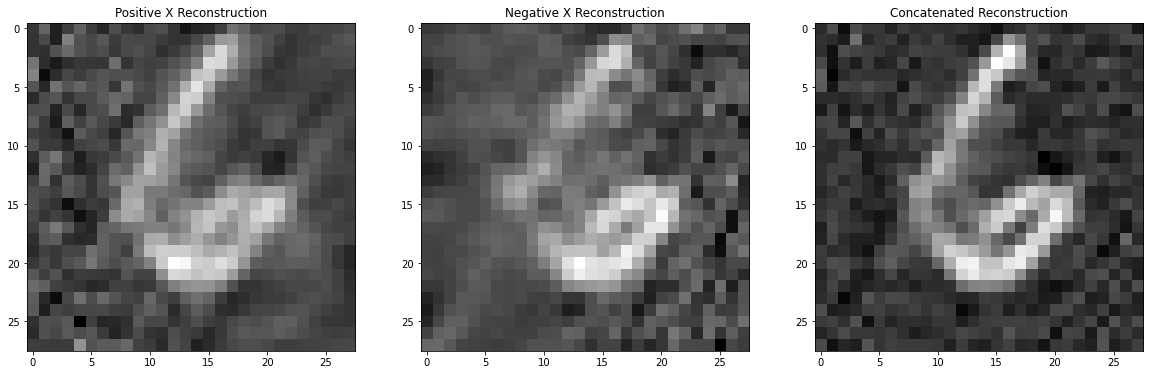

In [ ]:
plt.subplot(1,3,1)
plt.imshow(H_, cmap='gray')
plt.title('Positive X Reconstruction')

plt.subplot(1,3,2)
plt.imshow(H_rot, cmap='gray')
plt.title('Negative X Reconstruction')

plt.subplot(1,3,3)
plt.imshow(H_tot, cmap='gray')
plt.title('Concatenated Reconstruction')

##*This is a great result! However, what if we want to incorporate a projection along Y instead of a projection along X, as the problem suggests?*

*Let's rotate H by 90 degrees instead of 180 degrees. This will represent a projection through the coded aperture along the Y axis.*

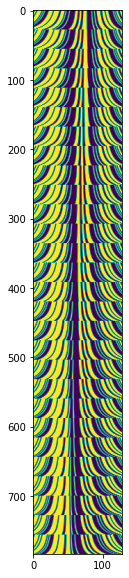

In [ ]:
H1=np.rot90(H)
plt.imshow(H1)

*Conceptually, it makes sense that concatenating this with our original matrix H and using an updated pseudoinverse would have the same effect as before. However, we cannot directly concatenate this rotated matrix with H, because the dimensions don't match.*

*To get around this, let's reshape the rotated matrix so that it is again 128 rows and 784 columns. This way, we do not lose any information, but we rearrange it for our needs.*

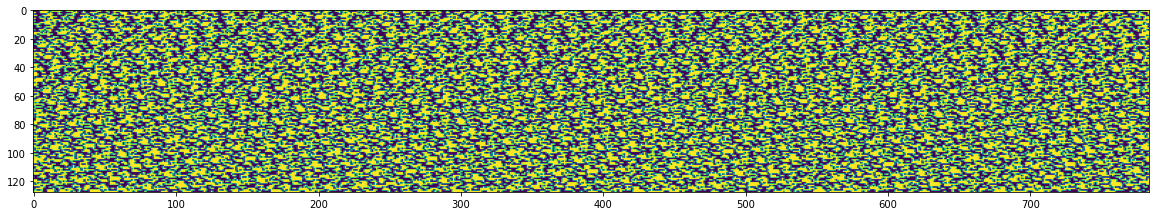

In [ ]:
H1=np.reshape(H1,(128,784))
plt.imshow(H1)

*Before concatenation, we can check to see what our rotated H matrix does when we apply its pseudoinverse for image reconstruction.*

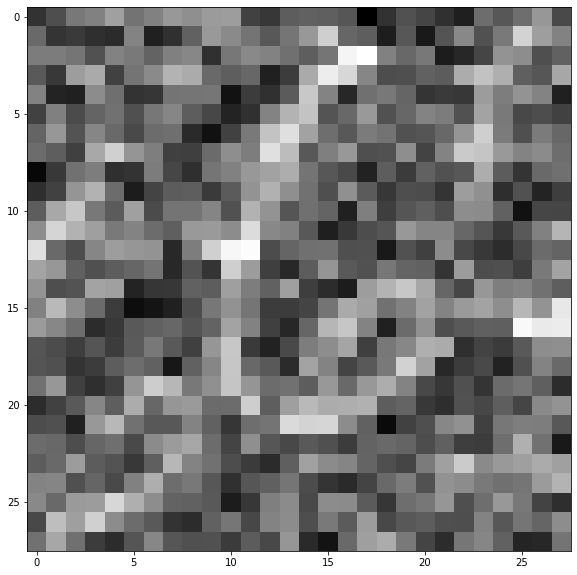

In [ ]:
H_1=np.reshape(np.matmul(np.linalg.pinv(H1),np.matmul(H1,np.reshape(x_train[32],N**2))),(N,N))
plt.imshow(H_1, cmap='gray')

*We see that the image is still reconstructed, but the blur pattern is different. I'd expect to see the blur pattern move from top to bottom since we rotate the projection by 90 degrees, however we rearranged the information in that matrix to be 128 rows by 784 columns. This changes the blur pattern of the image.*

*This is more akin to using a new random transmission filter, t, but the effect will still sharpen the image once we concatenate the matrix with our original H matrix.*

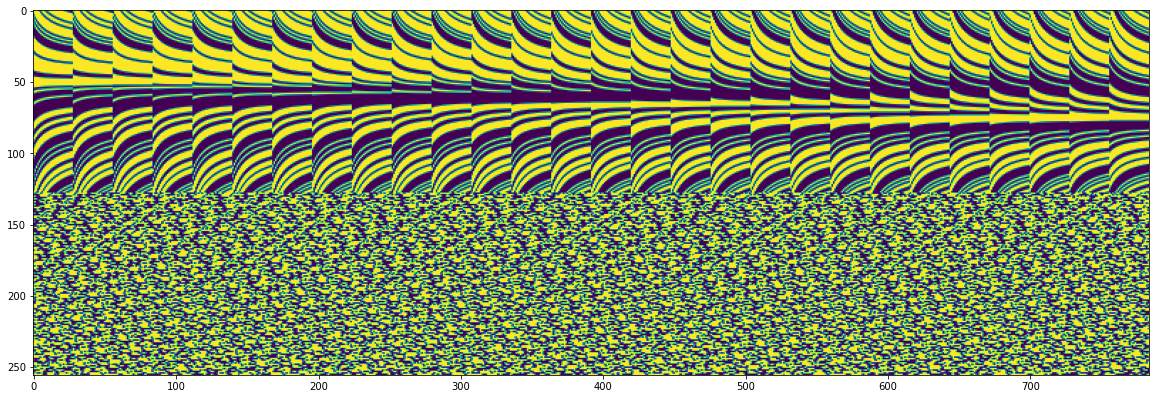

In [ ]:
Htot2=np.concatenate((H,H1), axis=0)
plt.imshow(Htot2)

*Now we can apply the concatenated matrix to the linear reconstruction. Using the psuedoinverse of the concatenated matrix again leads to a clearer reconstruction.*

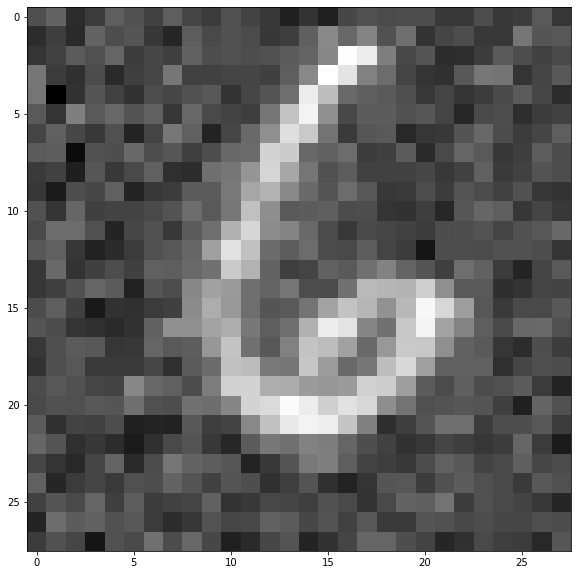

In [ ]:
H_tot2=np.reshape(np.matmul(np.linalg.pinv(Htot2),np.matmul(Htot2,np.reshape(x_train[32],N**2))),(N,N))
plt.imshow(H_tot2, cmap='gray')

*Here are the reconstructions we've accomplished so far.* 

*From left to right, the first three images are reconstruction after projection along positive X, after projection along negative X, and after concatenation of positive and negative X projections, respectively.*

*The 4th 5th and 6th images are reconstruction after projection along positive X, reconstruction after projection along positive Y with matrix reshaping, and reconstruction after concatenation of projection along positive X with projection along positive Y, respectively.* 

Text(0.5, 1.0, 'Positive X and Positive Y')

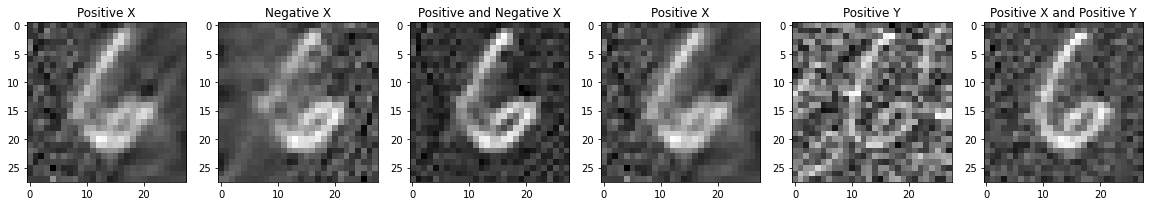

In [ ]:
plt.subplot(1,6,1)
plt.imshow(H_, cmap='gray')
plt.title('Positive X')

plt.subplot(1,6,2)
plt.imshow(H_rot, cmap='gray')
plt.title('Negative X')

plt.subplot(1,6,3)
plt.imshow(H_tot, cmap='gray')
plt.title('Positive and Negative X')

plt.subplot(1,6,4)
plt.imshow(H_, cmap='gray')
plt.title('Positive X')

plt.subplot(1,6,5)
plt.imshow(H_1, cmap='gray')
plt.title('Positive Y')

plt.subplot(1,6,6)
plt.imshow(H_tot2, cmap='gray')
plt.title('Positive X and Positive Y')

*Note that in both cases of concatenation, regardless of the projection directions are larger H matrix leads to a clearer result when its psuedoinverse is applied to the reconstruction. 

*What if we take this a step further and concatenate positive X projection, negative X projection, and positive Y projection?*

*Below is the new H matrix after concatenating all three projections. Note that the positive Y projection has been reshaped so that its dimesions are appropriate for concatenation.*

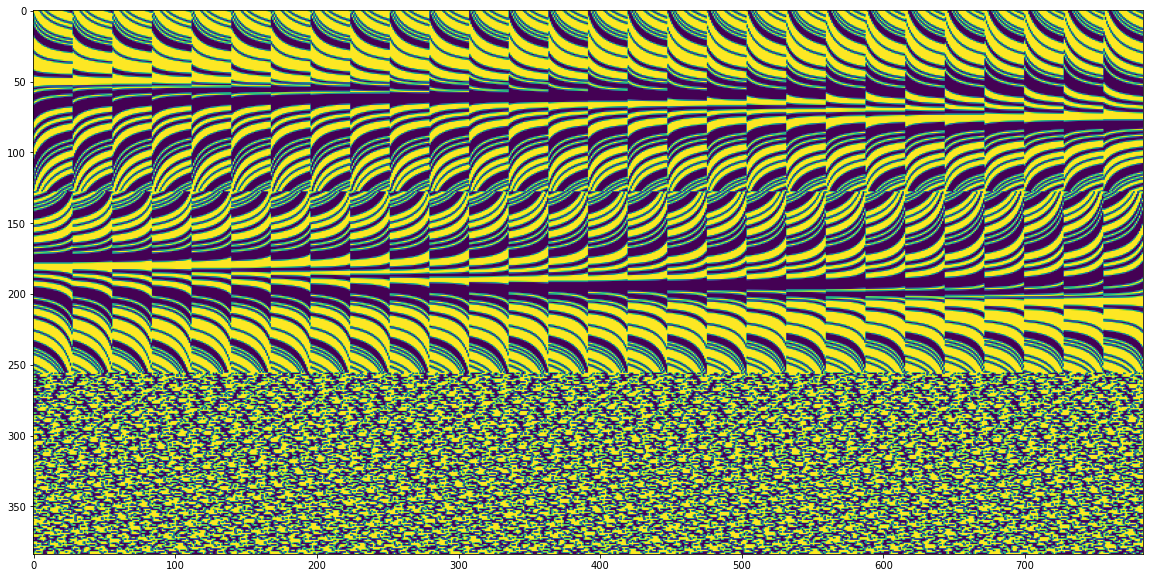

In [ ]:
Htot3=np.concatenate((Htot,H1), axis=0)
plt.imshow(Htot3)

*If we apply the pseudoinverse of this new H matrix to the image reconstruction, we expect the most improved result so far.*

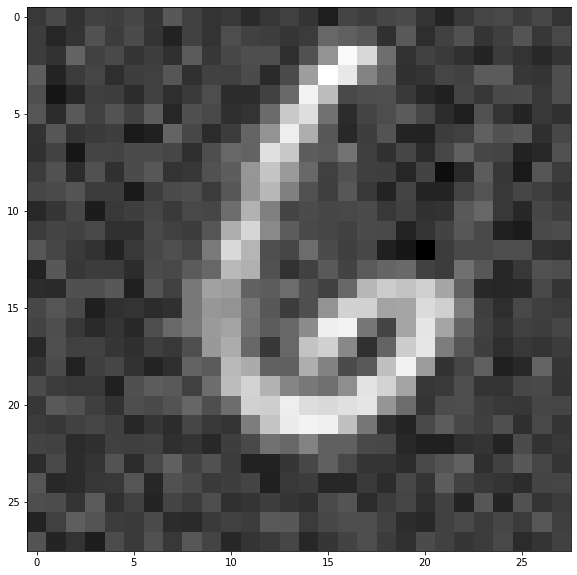

In [ ]:
H_tot3=np.reshape(np.matmul(np.linalg.pinv(Htot3),np.matmul(Htot3,np.reshape(x_train[32],N**2))),(N,N))
plt.imshow(H_tot3, cmap='gray')

*Here is a side by side comparison of the concatenated reconstructions thus far. Note how adding concatenations improves the reconstruction.*

Text(0.5, 1.0, 'Positive X, Negative X, and Positive Y')

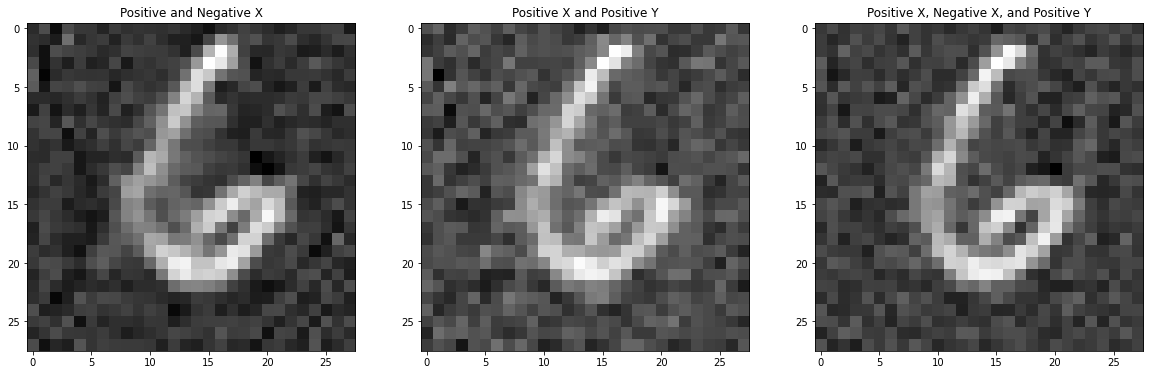

In [ ]:
plt.subplot(1,3,1)
plt.imshow(H_tot, cmap='gray')
plt.title('Positive and Negative X')

plt.subplot(1,3,2)
plt.imshow(H_tot2, cmap='gray')
plt.title('Positive X and Positive Y')

plt.subplot(1,3,3)
plt.imshow(H_tot3, cmap='gray')
plt.title('Positive X, Negative X, and Positive Y')

*What if we take the final step and include the 4th projection from negative Y? Here is the rotated H matrix for the negative Y projection.*

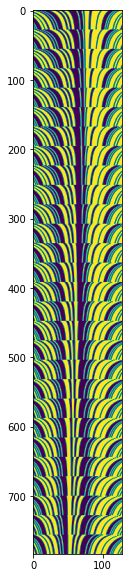

In [ ]:
H2 = np.rot90(H)
H2 = np.rot90(H2)
H2 = np.rot90(H2)
plt.imshow(H2)

*We must again reshape this matrix so the dimesions are suitable for concatenation.*

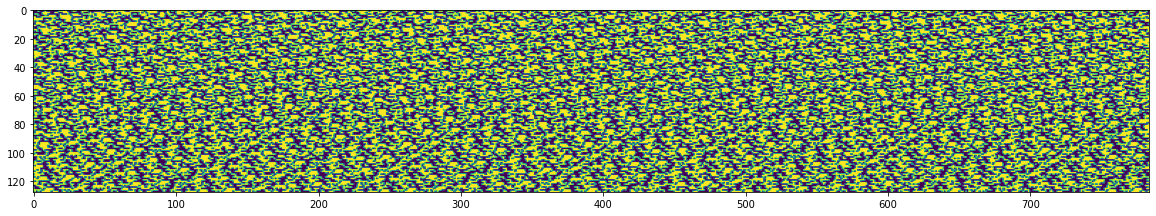

In [ ]:
H2=np.reshape(H2,(128,784))
plt.imshow(H2)

*Now we can concatenate all 4 of our rotated H matrices.*

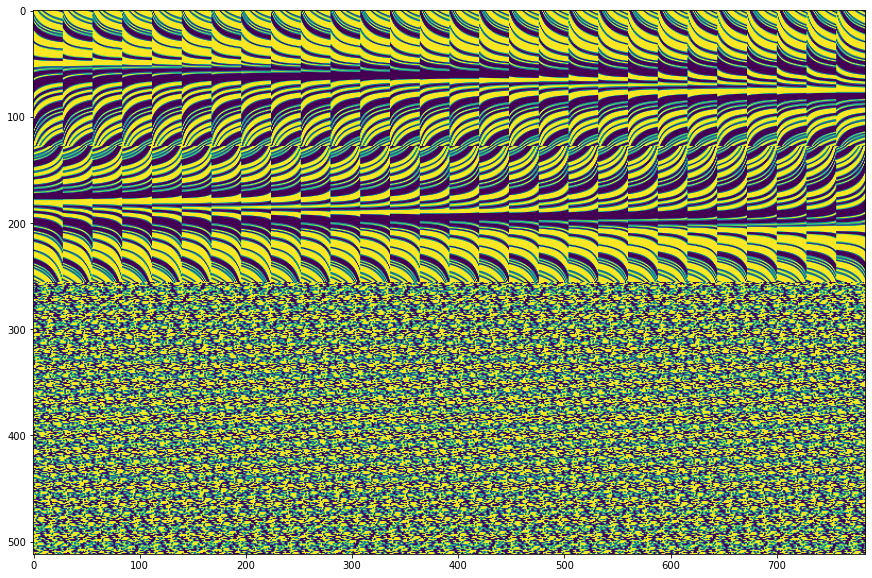

In [ ]:
Htot4=np.concatenate((Htot3,H2), axis=0)
plt.imshow(Htot4)

*Finally, we can apply this concatenated matrix to image reconstruction through the use of its pseudoinverse. Again, we get an even better result!*

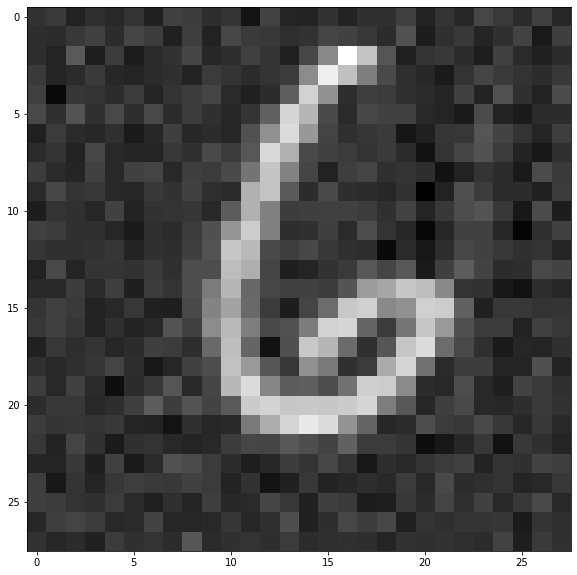

In [ ]:
H_tot4=np.reshape(np.matmul(np.linalg.pinv(Htot4),np.matmul(Htot4,np.reshape(x_train[32],N**2))),(N,N))
plt.imshow(H_tot4, cmap='gray')

*Below is the effect of using the pseudoinverse after a series of concatenations. Note that the image reconstruction becomes more accurate as we concatenate more projections from each of the cardinal directions.*

Text(0.5, 1.0, 'Along X, Y, -X, & -Y')

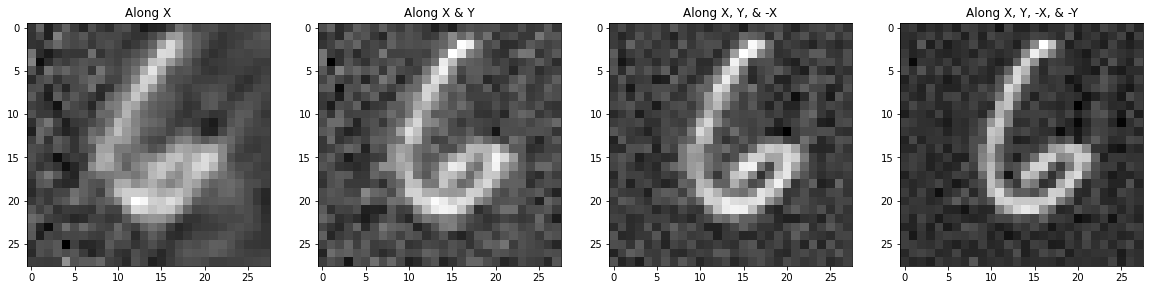

In [ ]:
plt.subplot(1,4,1)
plt.imshow(H_, cmap='gray')
plt.title('Along X')

plt.subplot(1,4,2)
plt.imshow(H_tot2, cmap='gray')
plt.title('Along X & Y')

plt.subplot(1,4,3)
plt.imshow(H_tot3, cmap='gray')
plt.title('Along X, Y, & -X')

plt.subplot(1,4,4)
plt.imshow(H_tot4, cmap='gray')
plt.title('Along X, Y, -X, & -Y')

### Major Takeaways

*2D reconstruction is possible from a set of 1D measurements using linear methods such as OLS. Taking projections from multiple directions and implementing concatenated versions of the data to create H increases the accuracy of the image reconstruction. This is because when we concatenate H, we improve the pseudoinverse used in the linear reconstruction.*

*This improvement comes from the fact that the pseudoinverse is only necessary in the first place because our selection for H is not full rank. Thus, the psuedoinverse is sparse. Adding concatenations to H makes H bigger, which means the pseudoinverse becomes less sparse. This ultimately leads to more accurate image reconstruction.*

*These ideas apply to coded aperture tomography because it is possible to take lower dimensional projections from multiple directions and combine them using linear image reconstruction methods to generate a higher dimensonal image. Improving the psuerdoinverse by combining multipled projections ultimately leads to a better result. In real life scenarios, this of course must be balanced with a cost function. For instance, taking more projections in X-ray tomography leads to more radiation exposure for the patient. We must balance the number of projections with the level of fidelity and resolution we require for the image reconstruction.*